# Deep Session 4차시 과제

# LeNet 구현해보기

<img src='http://drive.google.com/uc?export=view&id=1MevERvWOuYttJyTaFbGDJggB3luPD0TP' /><br>

LeNet-5는 32x32 크기의 흑백 이미지에서 학습된 7 layer Convolutional Neural Network  

[Conv(C1) - Subsampling(S2) - Conv(C3) - Subsampling(S4) - Conv(C5) - FC - FC]  

**Input**  
입력 이미지는 32x32  
**Layer C1**  
5x5 크기의 kernel 6개와 stride=1, convolutional layer  
입력 크기는 32x32x1 이고, 출력 크기는 28x28x6  
**Layer S2**
2x2 크기의 kernel 6개와 stride=2, subsampling layer  
입력 크기는 28x28x6 이고, 출력 크기는 14x14x6  
**Layer C3**  
5x5 크기의 kernel 16개와 stride=1, convolution layer  
입력 크기는 14x14x6 이고, 출력 크기는 10x10x16  
**Layer S4**  
2x2 크기의 kernel 16개와 stride=2, subsampling layer  
입력 크기는 10x10x16 이고, 출력 크기는 5x5x16  
**Layer C5**  
5x5 크기의 kernel 120개와 stride=1, convolutional layer  
입력 크기는 5x5x16 이고, 출력 크기는 1x1x120  
**Layer F6**  
tanh 함수를 활성화 함수로 이용하는 fully-connected layer  
입력 유닛은 120개 이고, 출력 유닛은 84개  
**Layer F7**  
RBF(Euclidean Radia Basis Function unit)를 활성화 함수로 이용하는 output layer  
입력 크기는 84 이고, 출력 크기는 10  
**Loss function**  
Loss function은 MSE(평균 제곱 오차)


In [2]:
# 필요한 라이브러리 import

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# parameters 설정

RANDOM_SEED = 42
LEARNING_RATE = 0.001 #변경
BATCH_SIZE = 32
N_EPOCHS = 10

In [4]:
#  정확도를 구하는 function과 손실을 시각화 하는 function 정의

def get_accuracy(model, data_loader, device):
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [5]:
# training data에 사용되는 helper 함수 정의하기

def train(train_loader, model, criterion, optimizer, device):
    '''
    training loop의 training 단계에 대한 함수
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # 순전파
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [6]:
# validation data에 사용되는 함수 정의

def validate(valid_loader, model, criterion, device):
    '''
    training loop의 validation 단계에 대한 함수
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [7]:
# training loop 정의

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    전체 training loop를 정의하는 함수
    '''
    
    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [15]:
from torchvision import datasets, transforms
# data 준비하기

# transforms 정의하기
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

## data augmentation 사용 x 성능 떨어짐

In [99]:

from torchvision import datasets, transforms
# transforms 정의하기
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                 transforms.RandomHorizontalFlip(),
                                 ])

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# 데이터 확인 1

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [9]:
# 데이터 확인 1

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 1, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


# <span style="color:purple">이부분 채우기</span>

In [16]:
# LeNet-5 구조 정의 
# nn.Conv2d, nn.AvgPool2d, nn.Linear를 이용해서 입력 이미지가 각 층을 통과하는 모양으로 만들기

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,stride=1)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size= 5, stride=1)
        self.conv3=nn.Conv2d(16,120, kernel_size=5, stride=1)
        self.fc1=nn.Linear(120,84)
        self.fc2=nn.Linear(84,10)
        #self.pool=nn.MaxPool2d(kernel_size=2,stride=2) # 최대값
        self.pool=nn.AvgPool2d(kernel_size = 2, stride = 2) #평균
        # 이 부분 채우기


    def forward(self, x):
        # 이 부분 채우기
        x = F.tanh(self.conv1(x))
        x = self.pool(x)
        x = F.tanh(self.conv2(x))
        x = self.pool(x)
        x= F.tanh(self.conv3(x))
        x= x.view(-1,120)
        x=F.tanh(self.fc1(x))
        x=self.fc2(x)
        probs= F.log_softmax(x, dim=1)
        return x,probs

In [17]:
# LeNet-5 구조 정의 
# nn.Sequential을 이용해서 ()괄호 안에 층들을 쌓아서 만들기

class LeNet5_Sequential(nn.Module):

    def __init__(self):
        super(LeNet5_Sequential, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride=1, padding = 0),
            nn.BatchNorm2d(6), #정규화
            nn.Tanh(),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            
            
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride=1, padding = 0),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            #nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride=1, padding = 0),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )
    
            
            # 이 부분 채우기

        self.classifier = nn.Sequential(
            nn.Linear(1 * 1 * 120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            
            # 이 부분 채우기
        )


    def forward(self, x):
        # 이 부분 채우기
        x = self.feature_extractor(x)
        
        x= x.view(-1,1 * 1* 120)
        
        x = self.classifier(x) 
        
        probs = F.log_softmax(x, dim=1)
        return x, probs

In [70]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

model = LeNet5().to(DEVICE)
#model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

15:31:34 --- Epoch: 0	Train loss: 0.1746	Valid loss: 0.0660	Train accuracy: 98.11	Valid accuracy: 97.84
15:32:07 --- Epoch: 1	Train loss: 0.0559	Valid loss: 0.0429	Train accuracy: 98.94	Valid accuracy: 98.57
15:32:38 --- Epoch: 2	Train loss: 0.0396	Valid loss: 0.0471	Train accuracy: 99.15	Valid accuracy: 98.54
15:33:14 --- Epoch: 3	Train loss: 0.0301	Valid loss: 0.0373	Train accuracy: 99.47	Valid accuracy: 98.79
15:33:47 --- Epoch: 4	Train loss: 0.0231	Valid loss: 0.0465	Train accuracy: 99.32	Valid accuracy: 98.66
15:34:18 --- Epoch: 5	Train loss: 0.0198	Valid loss: 0.0413	Train accuracy: 99.48	Valid accuracy: 98.84
15:34:53 --- Epoch: 6	Train loss: 0.0168	Valid loss: 0.0437	Train accuracy: 99.63	Valid accuracy: 98.72
15:35:24 --- Epoch: 7	Train loss: 0.0134	Valid loss: 0.0436	Train accuracy: 99.68	Valid accuracy: 98.71
15:35:56 --- Epoch: 8	Train loss: 0.0136	Valid loss: 0.0446	Train accuracy: 99.67	Valid accuracy: 98.80
15:36:27 --- Epoch: 9	Train loss: 0.0132	Valid loss: 0.0456	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


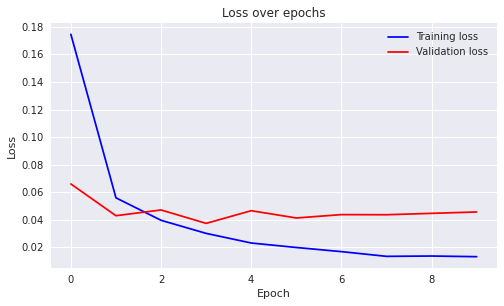

In [71]:
# 신경망 학습

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

In [81]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

#model = LeNet5().to(DEVICE)
model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

15:41:56 --- Epoch: 0	Train loss: 0.1826	Valid loss: 0.0756	Train accuracy: 97.66	Valid accuracy: 97.61
15:42:27 --- Epoch: 1	Train loss: 0.0693	Valid loss: 0.0580	Train accuracy: 98.48	Valid accuracy: 98.15
15:42:58 --- Epoch: 2	Train loss: 0.0535	Valid loss: 0.0591	Train accuracy: 98.55	Valid accuracy: 98.00
15:43:30 --- Epoch: 3	Train loss: 0.0485	Valid loss: 0.0556	Train accuracy: 98.66	Valid accuracy: 98.12
15:44:00 --- Epoch: 4	Train loss: 0.0429	Valid loss: 0.0464	Train accuracy: 98.94	Valid accuracy: 98.43
15:44:31 --- Epoch: 5	Train loss: 0.0387	Valid loss: 0.0442	Train accuracy: 99.08	Valid accuracy: 98.51
15:45:02 --- Epoch: 6	Train loss: 0.0385	Valid loss: 0.0508	Train accuracy: 99.03	Valid accuracy: 98.45
15:45:32 --- Epoch: 7	Train loss: 0.0347	Valid loss: 0.0502	Train accuracy: 99.09	Valid accuracy: 98.55
15:46:03 --- Epoch: 8	Train loss: 0.0347	Valid loss: 0.0503	Train accuracy: 99.11	Valid accuracy: 98.53
15:46:34 --- Epoch: 9	Train loss: 0.0336	Valid loss: 0.0517	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


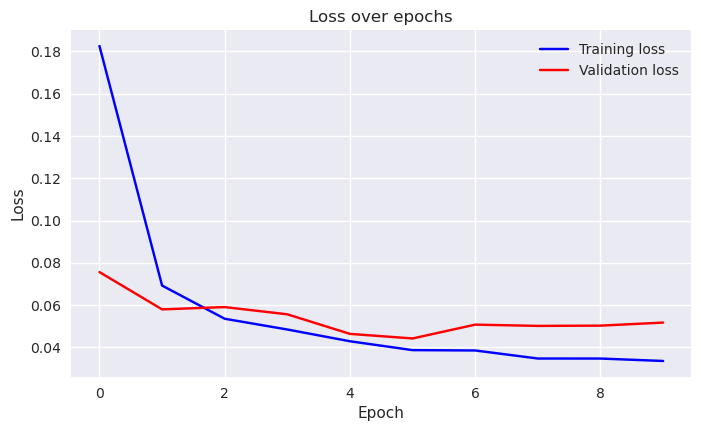

In [82]:
# 신경망 학습 

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

In [84]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

model = LeNet5().to(DEVICE)
#model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## AvgPool

C:\Users\Quantec\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


15:57:34 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
15:58:08 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
15:58:40 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
15:59:10 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
15:59:42 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.74
16:00:14 --- Epoch: 5	Train loss: 0.0297	Valid loss: 0.0439	Train accuracy: 99.36	Valid accuracy: 98.67
16:00:44 --- Epoch: 6	Train loss: 0.0246	Valid loss: 0.0418	Train accuracy: 99.53	Valid accuracy: 98.74
16:01:15 --- Epoch: 7	Train loss: 0.0218	Valid loss: 0.0482	Train accuracy: 99.41	Valid accuracy: 98.57
16:01:45 --- Epoch: 8	Train loss: 0.0200	Valid loss: 0.0436	Train accuracy: 99.60	Valid accuracy: 98.69
16:02:17 --- Epoch: 9	Train loss: 0.0168	Valid loss: 0.0515	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


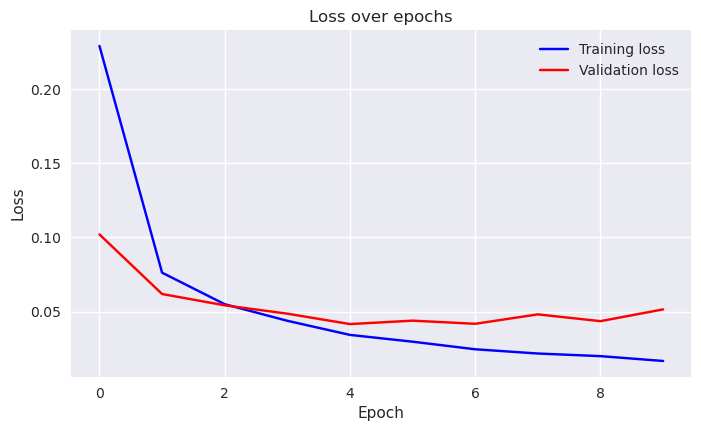

In [85]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

In [111]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

#model = LeNet5().to(DEVICE)
model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## batchnorm + avgpool

16:15:49 --- Epoch: 0	Train loss: 0.1512	Valid loss: 0.0640	Train accuracy: 97.93	Valid accuracy: 97.98
16:16:21 --- Epoch: 1	Train loss: 0.0645	Valid loss: 0.0521	Train accuracy: 98.43	Valid accuracy: 98.39
16:16:58 --- Epoch: 2	Train loss: 0.0506	Valid loss: 0.0361	Train accuracy: 99.12	Valid accuracy: 98.91
16:17:32 --- Epoch: 3	Train loss: 0.0431	Valid loss: 0.0452	Train accuracy: 98.62	Valid accuracy: 98.57
16:18:07 --- Epoch: 4	Train loss: 0.0371	Valid loss: 0.0443	Train accuracy: 98.96	Valid accuracy: 98.65
16:18:41 --- Epoch: 5	Train loss: 0.0321	Valid loss: 0.0320	Train accuracy: 99.29	Valid accuracy: 98.94
16:19:13 --- Epoch: 6	Train loss: 0.0282	Valid loss: 0.0265	Train accuracy: 99.51	Valid accuracy: 99.24
16:19:45 --- Epoch: 7	Train loss: 0.0258	Valid loss: 0.0316	Train accuracy: 99.44	Valid accuracy: 99.06
16:20:16 --- Epoch: 8	Train loss: 0.0221	Valid loss: 0.0295	Train accuracy: 99.57	Valid accuracy: 99.15
16:20:48 --- Epoch: 9	Train loss: 0.0210	Valid loss: 0.0292	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


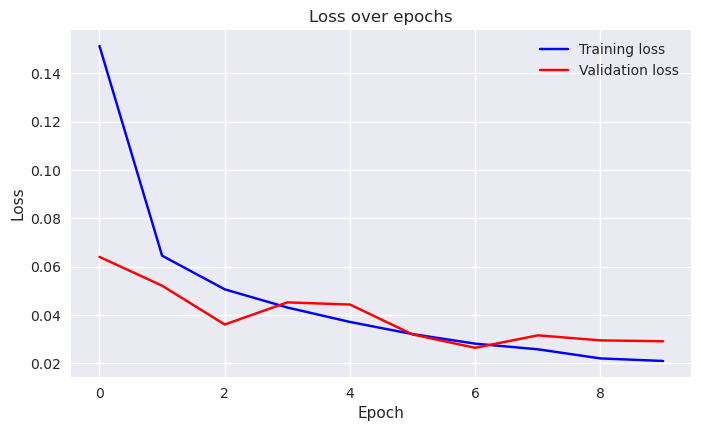

In [91]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

## data augmentation 예시 + avg pool + batch norm

16:28:22 --- Epoch: 0	Train loss: 0.2731	Valid loss: 0.1608	Train accuracy: 95.16	Valid accuracy: 94.84
16:29:00 --- Epoch: 1	Train loss: 0.1188	Valid loss: 0.1198	Train accuracy: 96.28	Valid accuracy: 96.38
16:29:35 --- Epoch: 2	Train loss: 0.0920	Valid loss: 0.0686	Train accuracy: 98.01	Valid accuracy: 97.87
16:30:12 --- Epoch: 3	Train loss: 0.0759	Valid loss: 0.0757	Train accuracy: 97.70	Valid accuracy: 97.25
16:30:49 --- Epoch: 4	Train loss: 0.0690	Valid loss: 0.0571	Train accuracy: 98.28	Valid accuracy: 98.08
16:31:26 --- Epoch: 5	Train loss: 0.0617	Valid loss: 0.0474	Train accuracy: 98.65	Valid accuracy: 98.42
16:32:05 --- Epoch: 6	Train loss: 0.0576	Valid loss: 0.0511	Train accuracy: 98.73	Valid accuracy: 98.34
16:32:42 --- Epoch: 7	Train loss: 0.0531	Valid loss: 0.0491	Train accuracy: 98.90	Valid accuracy: 98.57
16:33:19 --- Epoch: 8	Train loss: 0.0469	Valid loss: 0.0477	Train accuracy: 98.83	Valid accuracy: 98.40
16:33:54 --- Epoch: 9	Train loss: 0.0430	Valid loss: 0.0522	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


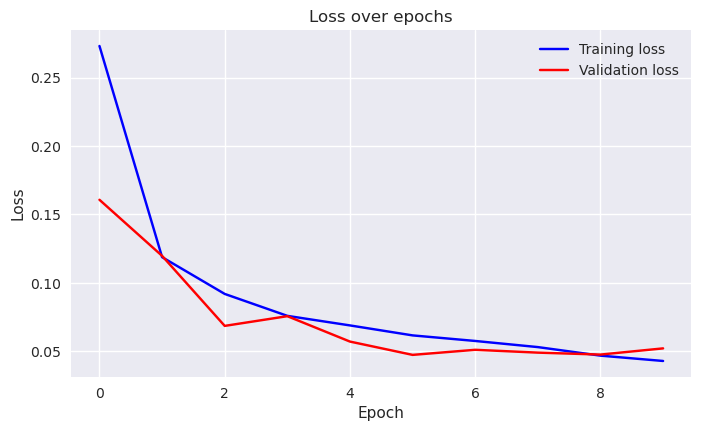

In [102]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

## avgpool + batchnorm + batchsize 64

16:46:58 --- Epoch: 0	Train loss: 0.1641	Valid loss: 0.0611	Train accuracy: 97.98	Valid accuracy: 98.05
16:47:31 --- Epoch: 1	Train loss: 0.0594	Valid loss: 0.0362	Train accuracy: 98.82	Valid accuracy: 98.92
16:48:04 --- Epoch: 2	Train loss: 0.0458	Valid loss: 0.0413	Train accuracy: 99.01	Valid accuracy: 98.78
16:48:36 --- Epoch: 3	Train loss: 0.0373	Valid loss: 0.0416	Train accuracy: 98.82	Valid accuracy: 98.69
16:49:08 --- Epoch: 4	Train loss: 0.0319	Valid loss: 0.0454	Train accuracy: 98.97	Valid accuracy: 98.65
16:49:40 --- Epoch: 5	Train loss: 0.0276	Valid loss: 0.0356	Train accuracy: 99.30	Valid accuracy: 98.90
16:50:13 --- Epoch: 6	Train loss: 0.0235	Valid loss: 0.0302	Train accuracy: 99.48	Valid accuracy: 99.03
16:50:53 --- Epoch: 7	Train loss: 0.0226	Valid loss: 0.0336	Train accuracy: 99.53	Valid accuracy: 98.97
16:51:32 --- Epoch: 8	Train loss: 0.0184	Valid loss: 0.0362	Train accuracy: 99.43	Valid accuracy: 98.90
16:52:07 --- Epoch: 9	Train loss: 0.0175	Valid loss: 0.0320	Trai

C:\Users\Quantec\AppData\Local\Temp\ipykernel_792\2877714773.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


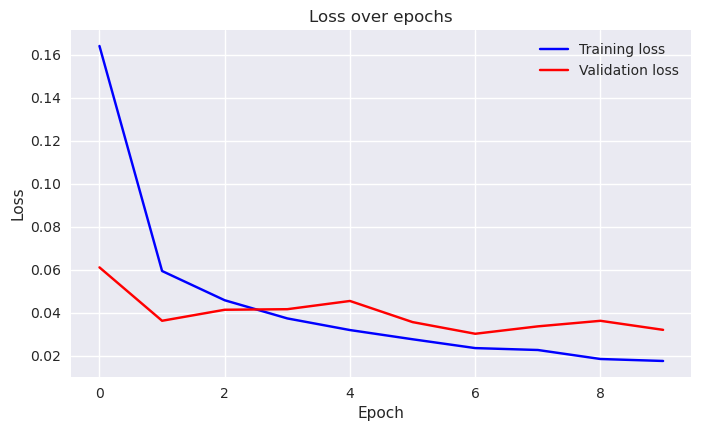

In [112]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

In [12]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

#model = LeNet5().to(DEVICE)
model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

log_softmax

## log_softmax + nllloss +batchnorm + avgpool + batch size 64

20:38:52 --- Epoch: 0	Train loss: -42.3376	Valid loss: -81.0038	Train accuracy: 96.71	Valid accuracy: 96.79
20:39:29 --- Epoch: 1	Train loss: -119.7189	Valid loss: -157.5497	Train accuracy: 98.21	Valid accuracy: 98.23
20:40:06 --- Epoch: 2	Train loss: -194.8249	Valid loss: -232.8078	Train accuracy: 98.78	Valid accuracy: 98.77
20:40:46 --- Epoch: 3	Train loss: -269.5059	Valid loss: -305.5180	Train accuracy: 98.56	Valid accuracy: 98.43
20:41:24 --- Epoch: 4	Train loss: -344.0494	Valid loss: -380.7263	Train accuracy: 99.01	Valid accuracy: 98.87
20:42:04 --- Epoch: 5	Train loss: -418.4782	Valid loss: -452.4911	Train accuracy: 98.68	Valid accuracy: 98.48
20:42:45 --- Epoch: 6	Train loss: -492.9498	Valid loss: -528.7305	Train accuracy: 99.10	Valid accuracy: 98.91
20:43:23 --- Epoch: 7	Train loss: -567.3890	Valid loss: -603.9504	Train accuracy: 99.36	Valid accuracy: 99.08
20:43:59 --- Epoch: 8	Train loss: -641.6334	Valid loss: -678.2315	Train accuracy: 99.44	Valid accuracy: 99.12
20:44:34 ---

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_33192/3643113671.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


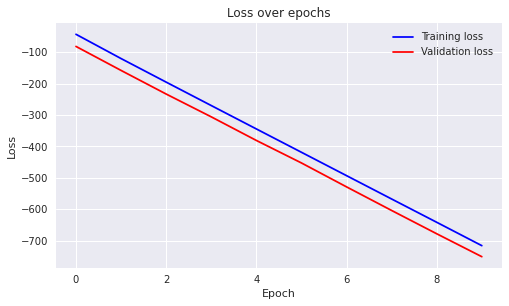

In [13]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

## log_softmax + nllloss +batchnorm + avgpool + batch size 32

In [19]:
# model, optimizer, loss function 설정하기

torch.manual_seed(RANDOM_SEED)

#model = LeNet5().to(DEVICE)
model = LeNet5_Sequential().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()


20:47:43 --- Epoch: 0	Train loss: -75.0672	Valid loss: -148.1414	Train accuracy: 97.92	Valid accuracy: 97.99
20:48:20 --- Epoch: 1	Train loss: -217.0334	Valid loss: -287.4679	Train accuracy: 98.15	Valid accuracy: 98.23
20:48:56 --- Epoch: 2	Train loss: -356.8686	Valid loss: -427.5502	Train accuracy: 98.76	Valid accuracy: 98.68
20:49:34 --- Epoch: 3	Train loss: -496.4949	Valid loss: -568.5889	Train accuracy: 99.11	Valid accuracy: 99.09
20:50:11 --- Epoch: 4	Train loss: -636.2904	Valid loss: -707.1204	Train accuracy: 99.09	Valid accuracy: 98.87
20:50:50 --- Epoch: 5	Train loss: -776.5176	Valid loss: -838.2112	Train accuracy: 98.36	Valid accuracy: 98.05
20:51:28 --- Epoch: 6	Train loss: -916.1951	Valid loss: -988.2156	Train accuracy: 99.31	Valid accuracy: 99.13
20:52:05 --- Epoch: 7	Train loss: -1056.3813	Valid loss: -1127.6604	Train accuracy: 99.39	Valid accuracy: 99.16
20:52:42 --- Epoch: 8	Train loss: -1196.0510	Valid loss: -1268.1703	Train accuracy: 99.42	Valid accuracy: 99.19
20:53:1

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_33192/3643113671.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


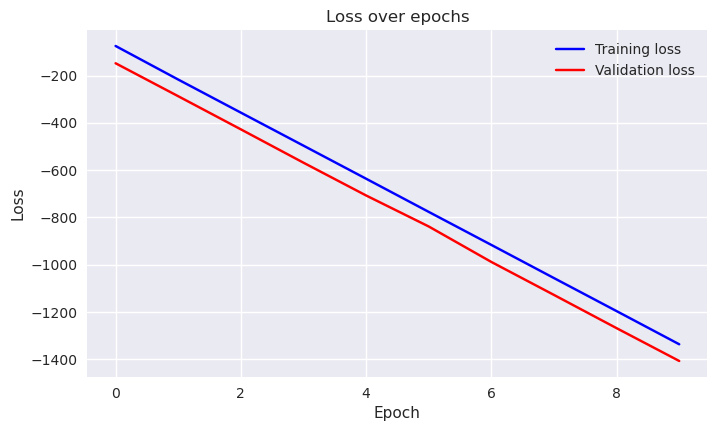

In [20]:


model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

### 추가적으로 seed, learning_rate, batch_size, epoch 값 등 변경해보기